# Simulation of a Correlated Field of Galaxies

## Introduction

### Context
Starburst galaxies are observed to be forming stars at an exceptionally high rate, about 10$^3$ times greater than observed in most galaxies, and are very bright in infrared. This phenomenon is linked to interactions or collisions between galaxies.
The study of the spatial distribution of those galaxies allow us to better understand how  interactions between galaxies affect star-formation and galaxy evolution.
There are two statistical ways to determine the spatial distribution of galaxies: the spatial correlation function and the power spectrum of cosmic infrared background (CIB) anisotropies.

### Goal
The goal of this project is to simulate a map of the sky in square degrees, containing points representing a correlated field of galaxies.

### Description of the Project
- Create a map with random galaxy distribution,
- Determine galaxy count at a given flux in far-infrared to build a map of Poisson distribution of galaxies,
- Spatially correlate the sources using the power spectrum of the CIB.

## Random Galaxy Distribution in a Map

Creation of a map of the sky with random distribution of galaxies

In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import warnings

# Suppressing all warning messages
warnings.filterwarnings("ignore")

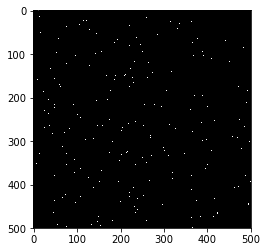

In [2]:
ng = 1000  # Number of galaxies
coord = 2  # Number of coordinates
a = np.random.random((ng,coord))  # Create random coordinates for the ng number of sources 

S = 1.0 # Random value used to mark the position of the galaxies on the map
pix = 500 # Size of the map in pixels

# Initialization of an array with zeros to create a map of 500 x 500 pixels
maps = np.zeros((pix,pix),dtype=np.float) 

# Marking the position of the galaxies in the map
for i in range (ng):
    maps[np.int(np.fix(a[i,0]*pix)),np.int(np.fix(a[i,1]*pix))] = S 

# Plotting the map of the sky with the randomly distributed galaxies
plt.imshow(maps,cmap=plt.get_cmap('gray'))
plt.show()


## Galaxy Count

To be able to simulate a field of galaxies, it is necessary to determine the galaxy count at a given frequency. 
The differential galaxy count is given by the power law :
$\frac{dN}{dS_{\nu}} \propto S_{\nu}^{-\frac{5}{2}}$.
In this case we use data observed at a frequency of 250 $\mu$m. At this frequency, the power law approximates as: 
$\frac{dN}{dS_{\nu}} \propto S_{\nu}^{-3.0}$.

### dNdS Function
I defined a function that returns the calculated differential galaxy count with given initial parameters.

In [3]:
# Function to calculate the galaxy count
def dnds (S,S0,N0):
    dNdS = N0/S0 * (S/S0)**(-3)
    return dNdS

### Mean Galaxy Number
I used the dnds function to determine the number of galaxies for each value of frequency. The number of galaxies is distributed with Poisson distribution and plotted on a map with fix number of pixels. The intensity of the points representing the galaxies will depend on the value of the frequency.

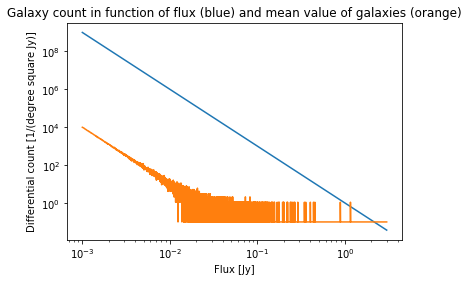

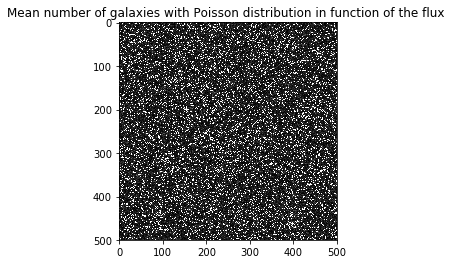

In [4]:
# Initial parameters for the dnds function and for galaxy count in function of the flux
N0 = 1.0
S0 = 1.0
S1 = 0.001
S2 = 3.0

dS = 0.00001 # Number of sources per 10**(-5) Jy

# Creating empty lists
tabdNdS = []
tabN = []
tabS = []

mapsize = 1.0 # Map size in square degrees
coord = 2 # Number of coordinates
pix = 500 # Number of pixels in the map
maps = np.zeros((pix,pix),dtype=np.float) # Creating a map of 500 x 500 pixels size

# Filling the empty lists with number of galaxies in function of the flux and 
# distributing the number of galaxies with a Poisson distribution
for S in np.arange(S1,S2,dS):
    dNdS = dnds(S,S0,N0)
    DN = dNdS*dS*mapsize
#    print(S)
#    print(dNdS)
    N = np.random.poisson(DN)
    tabdNdS.append(dNdS)
    tabN.append(N)
    tabS.append(S)     
#    print(N)

# Creating an array containing the values of the galaxy count for each frequency
tab = np.transpose([tabS,tabN])

# Creating random coordinates for the ng number of sources for each frequency
for i in range(len(tab)):
    s = tab[i][0]
    ng = tab[i][1]
#     print(ng)
    a = np.random.random((np.int(ng),coord))

# Marking the position of the galaxies in the map with different intensity
# corresponding to the value of frequency s
    for k in range(int(ng)):
        maps[np.int(np.fix(a[k,0]*pix)),np.int(np.fix(a[k,1]*pix))] = s
        
plt.figure(1)
plt.loglog(tabS,tabdNdS,tabS,np.array(tabN)+0.1)
plt.title('Galaxy count in function of flux (blue) and mean value of galaxies (orange)')
plt.ylabel('Differential count [1/(degree square Jy)]')
plt.xlabel('Flux [Jy]')

plt.figure(2)
plt.imshow(np.log(maps),cmap=plt.get_cmap('gray'))
plt.title('Mean number of galaxies with Poisson distribution in function of the flux ')

plt.show()

## Correlation
Here, I determined a correlated field of galaxies by creating a density field map containing 2D Gaussian fluctuations following Normal distribution.
The correlated map of this density field map is the Fourier Transform of the density field map.

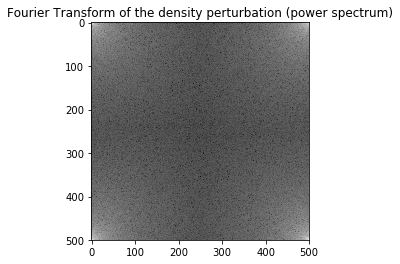

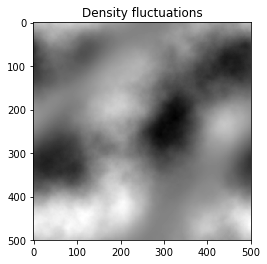

In [5]:
k0 = 0.01 # arcmin**(-1)
N = 500 # map size in pixels

fmaps = np.zeros((N,N),dtype=np.complex) # Defining a complex map corresponding to the density field
ifmaps = np.zeros((N,N),dtype=np.complex) # Defining a complex map

# Calculation of the Fast Fourier Transform on one half of the map,
# the values of the other half are the complex conjugates of the first half
for kx in range(N):
    for ky in range(N//2):

        if kx <= (N/2):
            kxp=kx

        else:
            kxp=N-kx-1
            
        # Calculation of initial Gaussian fluctuations with Normal Distribution
        if ((kxp != 0) or (ky != 0)):
            sigma = (kxp**2 + ky**2)**(-1.0)
            a = np.random.normal(0,sigma,1)  
            b = np.random.normal(0,sigma,1)
        if ((kxp == 0) and (ky == 0)):
            sigma = 0.0
            a=0
            b=0
        # Filling the map with the fluctuation values    
        fmaps[kx,ky] = np.complex(a,b)
        fmaps[N-kx-1,N-ky-1] = np.complex(a,-b)

# Calculation of the correlated density field
ifmaps = fft.ifft2(fmaps)

plt.figure(1)
plt.imshow(np.log(abs(fmaps)),cmap=plt.get_cmap('gray'))
plt.title('Fourier Transform of the density perturbation (power spectrum)')

plt.figure(2)
plt.imshow(np.real(ifmaps),cmap=plt.get_cmap('gray')) # Use of real to eliminate imaginary values from the fft
plt.title('Density fluctuations')

plt.show()